In [1]:
import os
import sys
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import collections
import sys
sys.path.append("/home/vip-lab/mrudul/SAMKD")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
sam_checkpoint = "/home/vip-lab/mrudul/SAMKD/checkpoints/sam_vit_h_4b8939.pth"  # Your SAM checkpoint
model_type = "vit_h"
# input_folder = ""
# output_folder = ""


# os.makedirs(output_folder, exist_ok=True)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# -------------------- LOAD SAM --------------------
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)
mask_generator = SamAutomaticMaskGenerator(sam)
sam.eval()


Using device: cuda


/home/vip-lab/mrudul/SAMKD/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class DomainDecoder(nn.Module):
    def __init__(self, in_channels=256, out_channels=1):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(in_channels, 128, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(32, out_channels, kernel_size=4, stride=2, padding=1)
        self.sigmoid = nn.Sigmoid()  # For binary segmentation

    def forward(self, z):
        x = F.relu(self.deconv1(z))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = self.sigmoid(self.deconv4(x))
        return x


In [3]:
import torch

sam.image_encoder.eval()
dummy_img = torch.randn(1, 3, 1024, 1024).to(device)


with torch.no_grad():
    features = sam.image_encoder(dummy_img)
print(features.shape)  # Should be [1, C, H, W]

out_channels = features.shape[1]  # Channel dimension

decoder = DomainDecoder(in_channels=out_channels)
decoder = decoder.to(device)


torch.Size([1, 256, 64, 64])


In [4]:
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Padding function to pad images and masks to 1024x1024
def pad_to_1024(img, mask, target_size=1024):
    w, h = img.size
    padded_img = Image.new("RGB", (target_size, target_size), (0, 0, 0))
    padded_mask = Image.new("L", (target_size, target_size), 0)
    left = (target_size - w) // 2
    top = (target_size - h) // 2
    padded_img.paste(img.convert("RGB"), (left, top))
    padded_mask.paste(mask, (left, top))
    return padded_img, padded_mask

# Dataset class with padding and transforms
class PaddedSegmentationDataset(Dataset):
    def __init__(self, image_folder, mask_folder, target_size=1024):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.target_size = target_size
        self.image_names = sorted(os.listdir(image_folder))
        self.mask_names = sorted(os.listdir(mask_folder))

        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_names[idx])
        mask_path = os.path.join(self.mask_folder, self.mask_names[idx])

        img = Image.open(img_path)  # Grayscale 227x227
        mask = Image.open(mask_path)  # Grayscale 227x227 (mask)

        # Pad images & masks to 1024x1024
        img_padded, mask_padded = pad_to_1024(img, mask, self.target_size)

        img_tensor = self.to_tensor(img_padded)  # [3, 1024, 1024]
        mask_tensor = self.to_tensor(mask_padded)  # [1, 1024, 1024]

        # Binarize mask
        mask_tensor = (mask_tensor > 0.5).float()

        return img_tensor, mask_tensor

# Paths to train images and masks
train_images_folder = "train_images"
train_masks_folder = "train_labels_resized"

# Create dataset and dataloader
train_dataset = PaddedSegmentationDataset(train_images_folder, train_masks_folder, target_size=1024)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)

# Your existing DomainDecoder class is assumed imported and the SAM model loaded as before




In [5]:
import torch.optim as optim
from torch.nn import BCELoss
import torch

# Criterion for binary segmentation
criterion = BCELoss()

# Optimizer for decoder only (SAM encoder is frozen)
optimizer = optim.Adam(decoder.parameters(), lr=5e-4)

# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

sam.to(device)
decoder.to(device)
sam.eval()  # Freeze SAM during training

def train_epoch(train_loader, sam, decoder, criterion, optimizer, device):
    decoder.train()
    running_loss = 0.0
    
    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()

        # Extract features using frozen SAM encoder
        with torch.no_grad():
            features = sam.image_encoder(imgs)
        
        # Decoder predicts masks from these features
        outputs = decoder(features)
        
        # Compute loss against ground truth masks
        loss = criterion(outputs, masks)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * imgs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss


# Usage
num_epochs = 25
best_loss = float('inf')

for epoch in range(num_epochs):
    loss = train_epoch(train_loader, sam, decoder, criterion, optimizer, device)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")

    # Save best model based on lowest training loss
    if loss < best_loss:
        best_loss = loss
        torch.save(decoder.state_dict(), "decoder_best.pth")
        print(f"Saved best model at epoch {epoch+1} with loss {loss:.4f}")


Using device: cuda
Epoch 1/25, Loss: 0.5860
Saved best model at epoch 1 with loss 0.5860
Epoch 2/25, Loss: 0.0396
Saved best model at epoch 2 with loss 0.0396
Epoch 3/25, Loss: 0.0217
Saved best model at epoch 3 with loss 0.0217
Epoch 4/25, Loss: 0.0166
Saved best model at epoch 4 with loss 0.0166
Epoch 5/25, Loss: 0.0147
Saved best model at epoch 5 with loss 0.0147
Epoch 6/25, Loss: 0.0140
Saved best model at epoch 6 with loss 0.0140
Epoch 7/25, Loss: 0.0132
Saved best model at epoch 7 with loss 0.0132
Epoch 8/25, Loss: 0.0127
Saved best model at epoch 8 with loss 0.0127
Epoch 9/25, Loss: 0.0122
Saved best model at epoch 9 with loss 0.0122
Epoch 10/25, Loss: 0.0120
Saved best model at epoch 10 with loss 0.0120
Epoch 11/25, Loss: 0.0116
Saved best model at epoch 11 with loss 0.0116
Epoch 12/25, Loss: 0.0114
Saved best model at epoch 12 with loss 0.0114
Epoch 13/25, Loss: 0.0111
Saved best model at epoch 13 with loss 0.0111
Epoch 14/25, Loss: 0.0109
Saved best model at epoch 14 with los

In [6]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Padding function matching training
def pad_to_1024(img, target_size=1024):
    w, h = img.size
    padded_img = Image.new("RGB", (target_size, target_size), (0, 0, 0))
    left = (target_size - w) // 2
    top = (target_size - h) // 2
    padded_img.paste(img.convert("RGB"), (left, top))
    return padded_img, left, top, w, h

# Crop function to inverse padding on predicted mask
def crop_mask(pred_mask, left, top, w, h):
    return pred_mask[top:top+h, left:left+w]

# Load your trained models (SAM + decoder)
# sam, decoder already initialized and weights loaded as before

def predict_mask(image_path, sam, decoder, device):
    # Load original grayscale image
    img = Image.open(image_path).convert("L")  # Grayscale; original size e.g. 227x227

    # Pad image to 1024x1024 RGB
    img_padded, left, top, w, h = pad_to_1024(img)

    # To tensor and normalize if needed
    transform = transforms.ToTensor()
    img_tensor = transform(img_padded).unsqueeze(0).to(device)  # Add batch dim

    sam.eval()
    decoder.eval()

    with torch.no_grad():
        features = sam.image_encoder(img_tensor)         # [1, C, 64, 64]
        output = decoder(features)                        # [1, 1, 1024, 1024]
    
    # Remove batch and channel dims
    pred_mask = output.squeeze().cpu().numpy()

    # Threshold to binary mask
    binary_mask = (pred_mask > 0.5).astype(np.uint8)

    # Crop predicted mask to original image size
    binary_mask_cropped = crop_mask(binary_mask, left, top, w, h)

    # Visualize overlay
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(img, cmap='gray')
    plt.imshow(binary_mask_cropped, cmap='jet', alpha=0.5)  # Overlay mask with transparency
    plt.title("Predicted Mask Overlay")
    plt.axis('off')
    plt.show()

    # Optionally return mask for other use
    return binary_mask_cropped

# Example usage


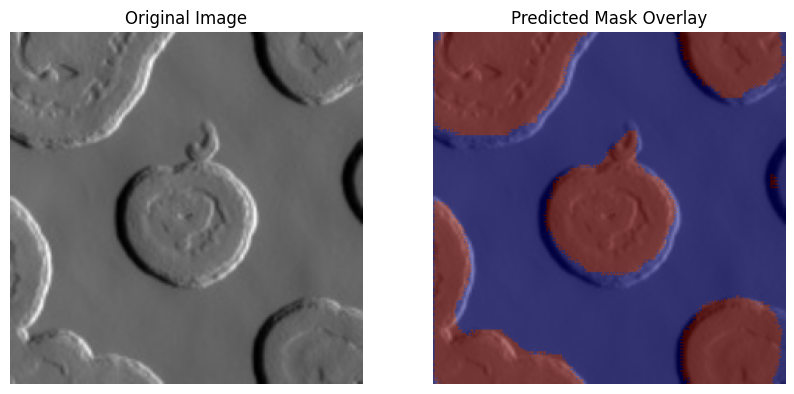

In [7]:
predicted_mask = predict_mask("/home/vip-lab/mrudul/SAMKD/ESP_012373_0930_RED-0147.jpg", sam, decoder, device)


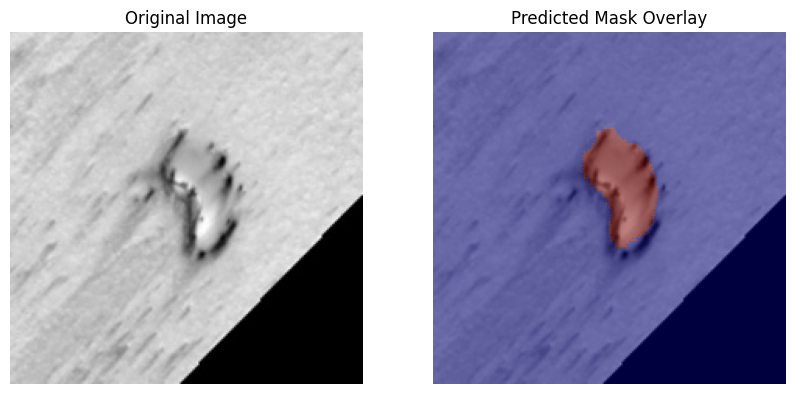

In [ ]:
predicted_mask = predict_mask("bright_dune.jpg", sam, decoder, device)


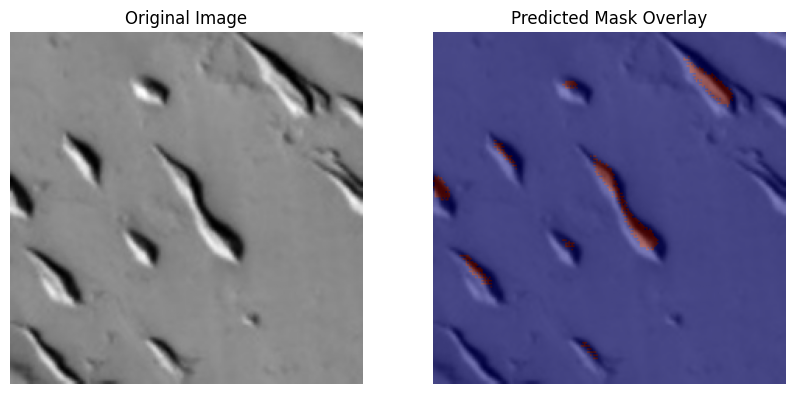

In [14]:
predicted_mask = predict_mask("test.jpg", sam, decoder, device)


In [13]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Dataset class for test data with padding to 1024x1024, similar to training
class TestSegmentationDataset(Dataset):
    def __init__(self, image_folder, mask_folder, target_size=1024):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.target_size = target_size
        self.image_names = sorted(os.listdir(image_folder))
        self.mask_names = sorted(os.listdir(mask_folder))
        self.to_tensor = transforms.ToTensor()

    def pad_to_1024(self, img):
        w, h = img.size
        padded_img = Image.new("RGB", (self.target_size, self.target_size), (0, 0, 0))
        left = (self.target_size - w) // 2
        top = (self.target_size - h) // 2
        padded_img.paste(img.convert("RGB"), (left, top))
        return padded_img, left, top, w, h

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.image_names[idx])
        mask_path = os.path.join(self.mask_folder, self.mask_names[idx])

        img = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        img_padded, left, top, w, h = self.pad_to_1024(img)
        mask_padded, _, _, _, _ = self.pad_to_1024(mask)

        img_tensor = self.to_tensor(img_padded)
        mask_tensor = self.to_tensor(mask_padded)
        mask_tensor = (mask_tensor > 0.5).float()  # Binarize mask tensor

        return img_tensor, mask_tensor, left, top, w, h

# Metric helper functions
def compute_iou(pred, target):
    intersection = (pred & target).sum()
    union = (pred | target).sum()
    iou = intersection / union if union > 0 else 1
    return iou

def compute_dice(pred, target):
    intersection = (pred & target).sum()
    dice = (2 * intersection) / (pred.sum() + target.sum()) if (pred.sum() + target.sum()) > 0 else 1
    return dice

def compute_recall(pred, target):
    tp = (pred & target).sum()
    fn = (target & (~pred)).sum()
    recall = tp / (tp + fn) if (tp + fn) > 0 else 1
    return recall

# Inference and evaluation function
def evaluate(test_loader, sam, decoder, device, threshold=0.5):
    sam.eval()
    decoder.eval()
    iou_scores, dice_scores, recall_scores = [], [], []

    with torch.no_grad():
        for imgs, masks, lefts, tops, ws, hs in test_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            features = sam.image_encoder(imgs)
            outputs = decoder(features)

            # Threshold outputs
            preds = (outputs > threshold).float()

            # Crop padded masks/predictions back to original size for metric calculation
            batch_size = imgs.shape[0]
            for i in range(batch_size):
                l, t, w, h = lefts[i].item(), tops[i].item(), ws[i].item(), hs[i].item()
                pred_crop = preds[i,0,t:t+h, l:l+w].cpu().bool()
                mask_crop = masks[i,0,t:t+h, l:l+w].cpu().bool()

                iou_scores.append(compute_iou(pred_crop, mask_crop))
                dice_scores.append(compute_dice(pred_crop, mask_crop))
                recall_scores.append(compute_recall(pred_crop, mask_crop))

    mean_iou = sum(iou_scores) / len(iou_scores)
    mean_dice = sum(dice_scores) / len(dice_scores)
    mean_recall = sum(recall_scores) / len(recall_scores)

    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Mean Dice (F1 score): {mean_dice:.4f}")
    print(f"Mean Recall: {mean_recall:.4f}")

    return mean_iou, mean_dice, mean_recall

# Usage
test_dataset = TestSegmentationDataset("test_images", "test_labels_resized", target_size=1024)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

evaluate(test_loader, sam, decoder, device)


Mean IoU: 0.5590
Mean Dice (F1 score): 0.7018
Mean Recall: 0.7167


(tensor(0.5590), tensor(0.7018), tensor(0.7167))